In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = 'data/'

data = pd.read_csv(DATA_PATH + 'p2-arbres-fr.csv', sep=';')

# Nettoyage des données

## Quelle variable pour l'espèce d'arbre ?

In [2]:
genre_na = data.genre.isna().sum()
genre_unique = data.genre.unique().shape
print(f"La variable 'genre' a {genre_na} valeurs manquantes pour {genre_unique} valeurs uniques.")

espece_na = data.espece.isna().sum()
espece_unique = data.espece.unique().shape
print(f"La variable 'espece' a {espece_na} valeurs manquantes pour {espece_unique} valeurs uniques.")

variete_na = data.variete.isna().sum()
variete_unique = data.variete.unique().shape
print(f"La variable 'variete' a {variete_na} valeurs manquantes pour {variete_unique} valeurs uniques.")

La variable 'genre' a 16 valeurs manquantes pour (176,) valeurs uniques.
La variable 'espece' a 1752 valeurs manquantes pour (540,) valeurs uniques.
La variable 'variete' a 163360 valeurs manquantes pour (437,) valeurs uniques.


La variable Genre comporte le moins de valeurs manquantes et le moins de valeurs uniques, ce qui rend l'analyse de la répartition des arbres plus pertinente et pratique. 

## Valeurs aberrantes 

### Hauteur

In [3]:
data.hauteur_m.sort_values(ascending=False).iloc[:20]

182852    881818
150101      5155
152110      2525
101985      2015
152205      1815
147984      1610
152437      1515
152238      1515
151382      1515
153314      1514
147229      1512
96481       1511
152339      1510
5392        1510
168580      1216
68681       1211
158359      1113
107327      1010
153036       818
151364       815
Name: hauteur_m, dtype: int64

In [4]:
data[data.hauteur_m > 30].shape

(573, 18)

On constate que beaucoup de valeurs de la variable hauteur_m sont aberrantes, aucun arbre ne fait jusqu'à 1km de haut, pas même 200m. 

Nos recherches ont montré que la taille maximale d'un arbre à Paris est 30m, et le nombre d'observations supérieures à ce nombre est négligeable face au total d'arbre dans la ville. Cependant, nous partons de l'hypothèse que les employés chargés des mesures ont rentrés les données en centimètres, et non pas en mètres. Afin de conserver ces données, nous avons décidé d'isoler les arbres de plus de 30m étant marqués comme juvéniles ou jeune adultes (J ou JA dans la variable stade_developpement) et de diviser leur hauteur par 100.


In [5]:
mask = ((data.hauteur_m > 30) & (data.stade_developpement.isin(['J', 'JA'])))
data[mask].shape

(355, 18)

355 valeurs ont donc pu être conservées, le reste est considéré comme non-significatif. Pour éviter les valeurs aberrantes, on supprime les 120 arbres malgré tout d'une taille supérieure à 50m

In [6]:
data.loc[mask, 'hauteur_m'] = data.loc[mask, 'hauteur_m'] / 100
data = data[(data.hauteur_m < 50)]

### Circonférence

Malheureusement, la circonférence varie beaucoup plus d'une espèce à l'autre, un cyprès peut être immense et très fin en comparaison d'un platane de même taille. 

C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='circonference_cm'>

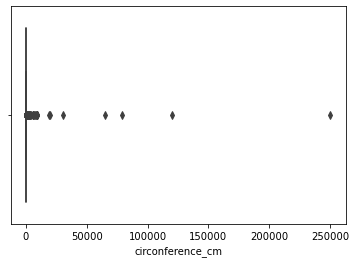

In [7]:
sns.boxplot(data.circonference_cm)

In [8]:
data.shape

(200009, 18)

In [9]:
data.circonference_cm.sort_values(ascending=False)[:20]

149056    250255
160432    120170
173343     79120
147634     65110
91256      30140
90605      20130
71787      18589
147235      9155
164616      9095
152303      9085
103437      9035
97354       8110
151364      7540
148106      6595
170367      6125
148481      6120
163918      6085
82951       5545
133546      4090
167606      3630
Name: circonference_cm, dtype: int64

Cela-dit, on peut être certains qu'aucun arbre ne fait plus de 15m de diamètre.

In [10]:
data[(data.circonference_cm > 1500)].shape

(35, 18)

Seulement 35 valeurs sont affectées, on décide donc de les supprimer du dataset

## Valeurs manquantes

In [11]:
data.isna().mean()

id                     0.000000
type_emplacement       0.000000
domanialite            0.000005
arrondissement         0.000000
complement_addresse    0.845667
numero                 1.000000
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.007485
genre                  0.000080
espece                 0.008760
variete                0.816198
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.335985
remarquable            0.315456
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

On se rend compte que le complément d'adresse, le numéro et la variété ont un nombre considérable de valeurs manquantes. Ce sont des valeurs que l'on doit supprimer pour l'analyse.

Les variables de lieu et de l'id de l'emplacement ne sont pas utiles à l'analyse et le type d'emplacement indique 'arbre' à chaque observation. 

Les variables 'remarquable' et 'stade_developpement' peuvent être utiles pour l'analyse, un tiers des valeurs sont manquantes mais le grand nombre d'observations compense ce manque.

In [12]:
data.id_emplacement

0                19
1                20
2                21
3                22
4          000G0037
            ...    
200132    720170151
200133    720170152
200134    720170153
200135    720170154
200136    720170155
Name: id_emplacement, Length: 200009, dtype: object

In [13]:
# Variables redondantes et presque vides
# On garde genre plutot que libelle car il y a plus de données et moins de modalités

var_inutiles = ['lieu', 'id_emplacement', 'type_emplacement']
var_vides = ['complement_addresse', 'numero', 'variete']
var_redondantes = ['espece', 'libelle_francais']

var_drop = var_inutiles + var_vides + var_redondantes

df = data.drop(var_drop, axis=1)

# Data Explo

## Domanialité

La domanialité représente un usage spécifique et réglementé de l'arbre en question, par exemple des restrictions de taille, de type d'arbre, de position..

In [14]:
temp = df.groupby(by='domanialite').count().id.sort_values(ascending=False)
dom_sum = temp.sum()
temp2 = (temp/dom_sum)*100

C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


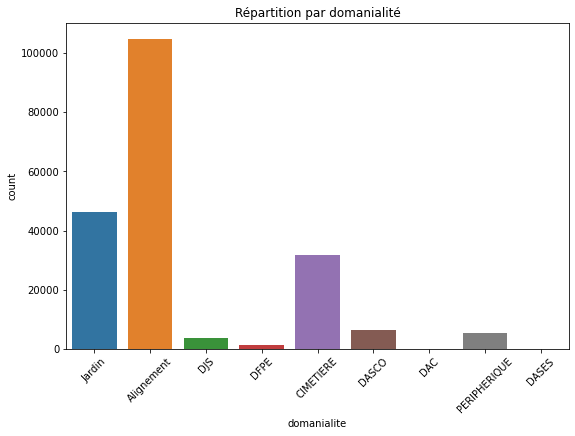

In [15]:
plot = sns.countplot(df.domanialite)
plot.set_title('Répartition par domanialité')
plt.xticks(rotation = 45)

fig = plt.gcf()
fig.set_size_inches(9, 6)
fig.savefig('graphs/repartition_dom.png', bbox_inches='tight')

Considérant que les arbres d'alignement, de jardin et de cimetière constituent plus de 95% des arbres traités, nous concentrons notre analyse sur ceux-ci

In [16]:
dom_list = ['Alignement', 'Jardin', 'CIMETIERE']
df = df[df.domanialite.isin(dom_list)]

In [17]:
df.domanialite.unique()

array(['Jardin', 'Alignement', 'CIMETIERE'], dtype=object)

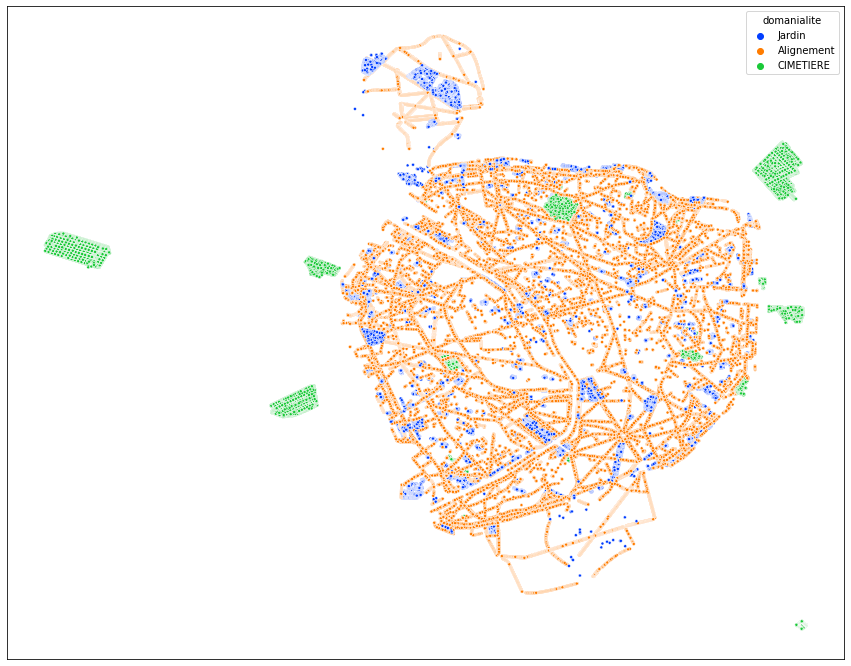

In [18]:
colors = {'Alignement':'orange', 'Jardin':'green', 'CIMETIERE':'purple'}

palette = sns.color_palette("bright", 3)
plot = sns.scatterplot(x = df.geo_point_2d_a, 
                       y = df.geo_point_2d_b, 
                       palette=palette, hue=df.domanialite,
                      marker = '.',
                      legend = 'full')

plot.set(xticklabels=[])
plot.set(xlabel=None)
plot.tick_params(bottom=False)
plot.set(yticklabels=[])
plot.set(ylabel=None)
plot.tick_params(left=False)

fig = plt.gcf()
fig.set_size_inches(15, 12)

fig.savefig('graphs/repartition_dom.png', bbox_inches='tight')

# Extraction des données pour l'analyse

In [19]:
# Extraction de datasets
from sklearn.preprocessing import OneHotEncoder

# Coordonnées 
data_geo = df[['geo_point_2d_a', 'geo_point_2d_b']]

# Dominalité
dom_list = ['Alignement', 'Jardin', 'CIMETIERE']

temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
temp = temp[temp.domanialite.isin(dom_list)]

new_name = {0: 'Alignement',
         1: 'CIMETIERE', 
         2: 'Jardin'}

dom = temp[['circonference_cm', 'hauteur_m', 'domanialite']].dropna()
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_dom = pd.DataFrame(encoder.fit_transform(dom[['domanialite']]).toarray())
final_dom = dom.join(encoder_dom)
final_dom.rename(columns = new_name, inplace = True)

# Age de l'arbre
temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
dev = temp[['circonference_cm', 'hauteur_m', 'stade_developpement']].dropna()

dev['A'] = dev['stade_developpement'] == 'A'
dev['J'] = dev['stade_developpement'] == 'J'
dev['M'] = dev['stade_developpement'] == 'M'
dev['JA'] = dev['stade_developpement'] == 'JA'

# Repartition en fonction de la domanialité
align = df[df['domanialite'] == 'Alignement']
jardin = df[df['domanialite'] == 'Jardin']
cimetiere = df[df['domanialite'] == 'CIMETIERE']

# Domanialité vs stade de développement
temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
full = temp[['stade_developpement', 'domanialite']].dropna()

full['A'] = full['stade_developpement'] == 'A'
full['J'] = full['stade_developpement'] == 'J'
full['M'] = full['stade_developpement'] == 'M'
full['JA'] = full['stade_developpement'] == 'JA'
full['Alignement'] = full['domanialite'] == 'Alignement'
full['Cimetière'] = full['domanialite'] == 'CIMETIERE'
full['Jardin'] = full['domanialite'] == 'Jardin'

# Analyse

## Domanialite

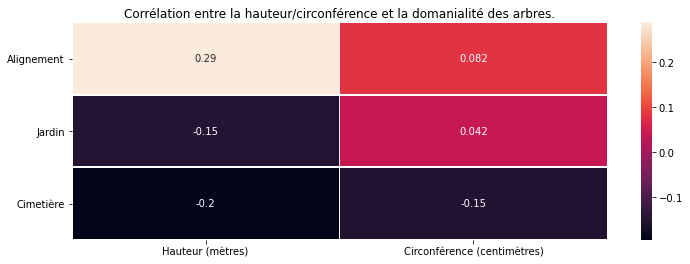

In [20]:
cr = final_dom.corr()
final_cr = cr.loc[['Alignement', 'Jardin', 'CIMETIERE'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])
plot.set_yticklabels(['Alignement', 'Jardin', 'Cimetière'])
plot.set_title('Corrélation entre la hauteur/circonférence et la domanialité des arbres.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Domanialité_taille_corr.png', bbox_inches='tight')

On trouve une corrélation entre la domanialité et les dimensions des arbres.

Ainsi, l'équipe consacrée à l'entretien des alignements devra s'équiper pour traiter des arbres plus massifs que ceux des cimetières

In [21]:
df[['domanialite', 'hauteur_m', 'circonference_cm']].groupby(by = 'domanialite').mean()

,hauteur_m,circonference_cm
domanialite,,
Alignement,10.007827,92.070986
CIMETIERE,5.894061,61.939748
Jardin,6.118908,78.582876


C'est une donnée qu'on retrouve dans l'analyse de la moyenne. Les arbres sont en moyenne plus haut et épais le long des routes.

Cela est moins évident concernant les cimetières et les jardins.

In [22]:
df[['domanialite', 'hauteur_m', 'circonference_cm']].groupby(by = 'domanialite').std()

,hauteur_m,circonference_cm
domanialite,,
Alignement,5.265071,925.565891
CIMETIERE,7.041474,77.574727
Jardin,6.754124,75.447328


De plus il y a une grande disparité entre les arbres d'alignement. 

On soumet ça à un test statistique pour déterminer si la différence est significative

In [23]:
from math import sqrt

def mean_equal(df1, df2):
    '''Tests a significative difference in mean between two series.
    Returns (t_stat, degrees of freedom)
    We wish to test the hypothesis at the a = 0.05
    As per https://www.unm.edu/~marcusj/2Sampletex2.pdf
    '''
    mn1 = df1.mean()
    samp_size1 = df1.shape[0]
    sd1 = df1.std()
    
    mn2 = df2.mean()
    samp_size2 = df2.shape[0]
    sd2 = df2.std()
    
    # This is the Sattherwaite stat, a formula used to find 
    # the "effective degrees of freedom" in a two-sample t-test.
    SE_stat = sqrt(((sd1**2)/samp_size1)+((sd2**2)/samp_size2))
    # We can take into account both unequal variances and 
    # unequal sample sizes at the same time.
    
    # To calculate a p value and compare it to our a, the t-test statistic is:
    t_stat = (mn1 - mn2)/SE_stat
    
    # To find out critical stat value, we need to compute v
    # It's ugly but we don't need to know what it means
    v_num = (((sd1**2)/samp_size1)+((sd2**2)/samp_size2))**2
    v_denom = (((sd1**2)/samp_size1)**2/(samp_size1-1)) + (((sd2**2)/samp_size2)**2/(samp_size2-1))**2
    v = round(v_num / v_denom)
    
    return t_stat, v

In [37]:
hauteur_jardin = df[df.domanialite == 'Jardin'].hauteur_m
hauteur_alignement = df[df.domanialite == 'Alignement'].hauteur_m
hauteur_cimetiere = df[df.domanialite == 'CIMETIERE'].hauteur_m

mean_equal(hauteur_jardin, hauteur_alignement)

(-109.96339465037548, 74366, 0.03536557159053502)

La statistique (-109) est si éloignée des deux moyennes que l'ont peu exclure l'hypothèse d'égalité et considerer que les arbres des jardin ont une hauteur très significativement différente des arbres d'alignement.

In [38]:
mean_equal(hauteur_jardin, hauteur_cimetiere)

(4.461508984199883, 306670, 0.05039708297017512)

In [39]:
print(f"[{(hauteur_jardin.mean() - hauteur_cimetiere.mean()) - 0.0503*1.96}; {(hauteur_jardin.mean() - hauteur_cimetiere.mean()) + 0.0503*1.96}]")

[0.12625903844890318; 0.3234350384489032]


La statistique 4.46 est en dehors de l'intervalle, on considère alors que les arbres de jardin ont une hauteur significativement différente des arbres de cimetière.

In [42]:
mean_equal(hauteur_alignement, hauteur_cimetiere)

(96.48352726812922, 4957262, 0.042636970898283964)

In [43]:
print(f"[{(hauteur_alignement.mean() - hauteur_cimetiere.mean()) - 0.042*1.96}; {(hauteur_alignement.mean() - hauteur_cimetiere.mean()) + 0.042*1.96}]")

[4.031445344295013; 4.196085344295013]


La statistique 4.46 est en dehors de l'intervalle, on considère alors que les arbres d'alignement ont une hauteur significativement différente des arbres de cimétière, très probablement plus grande.

Ainsi on peut conclure que les arbres d'alignement sont nettement plus grands que les arbres de jardin ou de cimetière, ils sont par ailleurs nettement plus épais (montré par des calculs similaires). 
**Cela nous mène à penser que l'envergure de l'entretien des arbres d'alignement réclame un équipement spécifique plus régulièrement que les autres dominalités.**

## Stade de développement

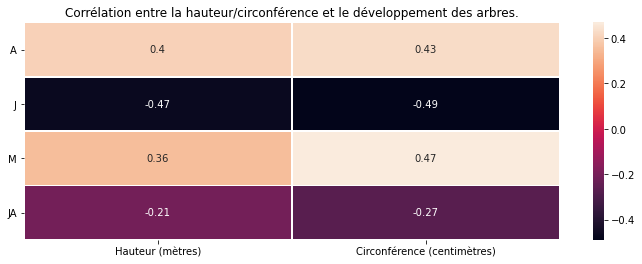

In [25]:
cr = dev.corr()
final_cr = cr.loc[['A', 'J', 'M', 'JA'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre la hauteur/circonférence et le développement des arbres.')
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_taille_corr.png', bbox_inches='tight')

J > JA > M > A

## Stade de développement vs domanialité

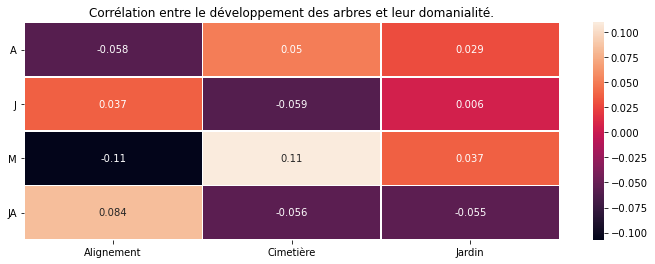

In [26]:
cr = full.corr().loc[['A', 'J', 'M', 'JA'], ['Alignement', 'Cimetière', 'Jardin']]

plot = sns.heatmap(cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre le développement des arbres et leur domanialité.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_domanialité_corr.png', bbox_inches='tight')

## Domanialité vs espèces

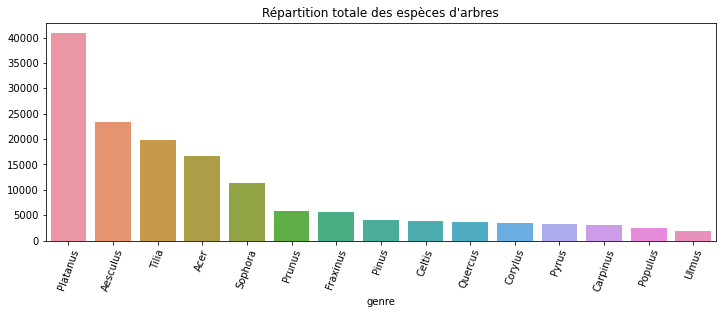

In [27]:
# Repartition totale des espèces

temp = df.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
most_trees = temp.index.to_list()
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition totale des espèces d'arbres")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/genre_répartition.png', bbox_inches='tight')

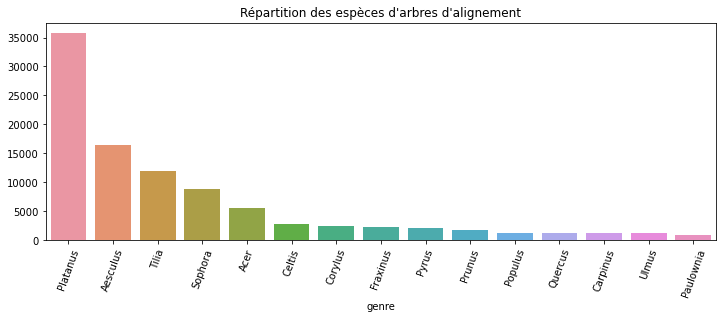

In [28]:
# Répartition des alignements

temp = align.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres d'alignement")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/alignement_genre_répartition.png', bbox_inches='tight')

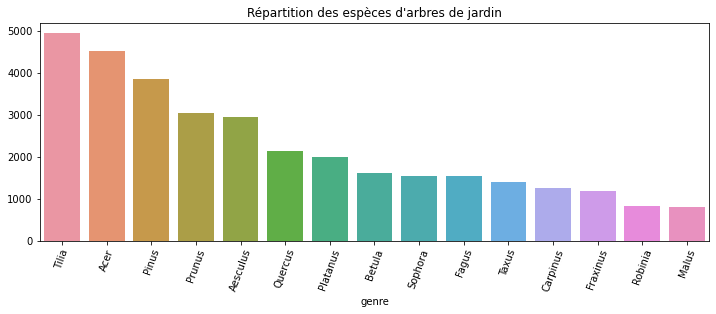

In [29]:
# Répartition des jardins

temp = jardin.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres de jardin")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/jardin_genre_répartition.png', bbox_inches='tight')

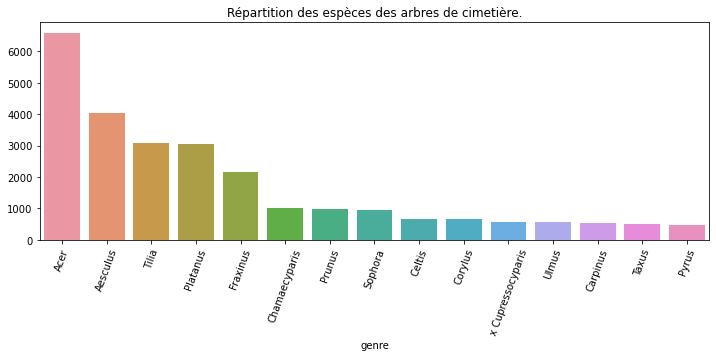

In [30]:
# Répartition des cimetières

temp = cimetiere.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set_title('Répartition des espèces des arbres de cimetière.')

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/cimetière_genre_répartition.png', bbox_inches='tight')

In [31]:
from math import sqrt

def mean_equal(df1, df2):
    '''Tests a significative difference in mean between two series.
    Returns (t_stat, degrees of freedom, estimation of standard deviation)
    We wish to test the hypothesis at the a = 0.05
    As per https://www.unm.edu/~marcusj/2Sampletex2.pdf
    df1 and df2 are pandas series.
    ------
    1. Use the a and the degrees of freedom to look up the student critical value
    2. Multiply that critical value by the estimation of standard deviation
    3. Compute the mean and substract/add the value computed in 2 to build an interval
    4. If the t_stat value is out of the interval, reject the null hypothesis of equality
    '''
    mn1 = df1.mean()
    samp_size1 = df1.shape[0]
    sd1 = df1.std()
    
    mn2 = df2.mean()
    samp_size2 = df2.shape[0]
    sd2 = df2.std()
    
    # This is the Sattherwaite stat, a formula used to find 
    # the "effective degrees of freedom" in a two-sample t-test.
    SE_stat = sqrt(((sd1**2)/samp_size1)+((sd2**2)/samp_size2))
    # We can take into account both unequal variances and 
    # unequal sample sizes at the same time.
    
    # To calculate a p value and compare it to our a, the t-test statistic is:
    t_stat = (mn1 - mn2)/SE_stat
    
    # To find out critical stat value, we need to compute v
    # It's ugly but we don't need to know what it means
    v_num = (((sd1**2)/samp_size1)+((sd2**2)/samp_size2))**2
    v_denom = (((sd1**2)/samp_size1)**2/(samp_size1-1)) + (((sd2**2)/samp_size2)**2/(samp_size2-1))**2
    v = round(v_num / v_denom)
    
    return t_stat, v, SE_stat

In [32]:
hauteur_jardin = df[df.domanialite == 'Jardin'].hauteur_m
hauteur_alignement = df[df.domanialite == 'Alignement'].hauteur_m
hauteur_cimetiere = df[df.domanialite == 'CIMETIERE'].hauteur_m

In [33]:
mean_equal(df[df.domanialite == 'Jardin'].hauteur_m, df[df.domanialite == 'Alignement'].hauteur_m)

(-109.96339465037548, 74366, 0.03536557159053502)

Avec une valeur de student si éloignée de l'écart des deux moyennes, il est sûr et certain que l'hypothèse nulle d'égalité des moyennes est rejetée.

In [34]:
print(mean_equal(df[df.domanialite == 'Jardin'].hauteur_m, df[df.domanialite == 'CIMETIERE'].hauteur_m))
print(f"[{hauteur_jardin.mean() - hauteur_jardin.std()*1.96}; {hauteur_cimetiere.mean() + hauteur_cimetiere.std()*1.96}]")


(4.461508984199883, 306670, 0.05039708297017512)
[-7.119174072783029; 19.695351069299768]


4.46 étant inclu dans l'intervalle, on considère que la différence de hauteur des arbres entre les jardins et les cimetières n'est pas significative

In [35]:
print(mean_equal(df[df.domanialite == 'Alignement'].hauteur_m, df[df.domanialite == 'CIMETIERE'].hauteur_m))
print(f"[{hauteur_alignement.mean() - hauteur_alignement.std()*1.96}; {hauteur_cimetiere.mean() + hauteur_cimetiere.std()*1.96}]")


(96.48352726812922, 4957262, 0.042636970898283964)
[-0.311713454987375; 19.695351069299768]


96.48 n'étant pas inclu dans l'intervalle, on considère que la différence de hauteur des arbres entre les alignements et les cimetières est significative. 